# UTILS FILE

In [3]:
import os
import random
import tempfile

from collections import defaultdict
from dataclasses import dataclass
from typing import Callable, TypeAlias

import numpy as np
from numpy.testing import assert_almost_equal

from matplotlib import animation
import matplotlib.pyplot as plt
from matplotlib import colors
from IPython.display import Image

class Cell():
    START  = 'S'
    TARGET = 'T'
    EMPTY  = 'E'
    WALL   = 'W'
    BOMB   = 'B'
    GLORY  = 'G'
    NUKE   = 'N'

class Grid:
    def __init__(self, spec: list[str]):
        self.height = len(spec)
        self.width  = len(spec[0])
        self.cells  = [[col for col in [*row]] for row in spec]

    def __str__(self) -> str:
        return '\n'.join([' '.join([col.value for col in row]) for row in self.cells]).strip()

    def __getitem__(self, key) -> Cell:
        x, y = key
        return self.cells[self.height - y - 1][x]

class Action():
    UP    = 1
    RIGHT = 2
    DOWN  = 3
    LEFT  = 4

@dataclass(frozen=True)
class State:
    x: int = 0
    y: int = 0

    def pos(self) -> tuple[int]:
        return (self.x, self.y)

class GridMDP:
    def __init__(self, grid: Grid, start = State(), gamma = 1.0):
        self.grid = grid
        self.start = start
        self.gamma = gamma
        self.all_actions = [1, 2, 3, 4]
        # Arguably, we could filter out the non-reachable states here - but we keep things simple.
        self.all_states = [State(x, y) for x in range(0, self.grid.width)
                           for y in range(0, self.grid.height)]

    def is_terminal(self, state: State) -> bool:
        cell = self.grid[state.pos()]
        return cell in [Cell.TARGET, Cell.GLORY, Cell.BOMB, Cell.NUKE]

    def is_reachable(self, n: State) -> bool:
        return n.x >= 0 and n.x < self.grid.width \
                and n.y >= 0 and n.y < self.grid.height \
                and self.grid[n.pos()] != Cell.WALL

    def reward(self, state: State, action: Action, next_state: State) -> float:
        match self.grid[next_state.pos()]:
            case Cell.TARGET:
                return 1.0 * self.gamma
            case Cell.GLORY:
                return 10.0 * self.gamma
            case Cell.BOMB:
                return -1.0 * self.gamma
            case Cell.NUKE:
                return -10.0 * self.gamma
            case _:
                return 0.0

    def transition(self, state: State, action: Action, noise = 0.0) -> dict[State, float]:
        if not self.is_reachable(state) or self.is_terminal(state):
            return {}

        def landing(candidate: State) -> State:
            return candidate if self.is_reachable(candidate) else state

        action_landings = {
            Action.UP:    landing(State(state.x, state.y + 1)),
            Action.RIGHT: landing(State(state.x + 1, state.y)),
            Action.DOWN:  landing(State(state.x, state.y - 1)),
            Action.LEFT:  landing(State(state.x - 1, state.y)),
        }
        mistaken_actions = [Action.UP, Action.DOWN] if action in [Action.LEFT, Action.RIGHT] \
                                                    else [Action.LEFT, Action.RIGHT]

        next_state = action_landings[action]
        mistakes = [action_landings[m] for m in mistaken_actions]

        probs = defaultdict(lambda: 0.0)
        probs[next_state] = 1.0 - noise
        for m in mistakes:
            probs[m] += noise / len(mistakes)

        assert sum(probs.values()) <= 1.0
        assert_almost_equal(sum(probs.values()), 1.0)

        return probs

class GridEnv:
    def __init__(self, mdp: GridMDP):
        self.mdp = mdp
        self.state = State()
        self.terminated = False

    def reset(self) -> State:
        self.state = State()
        self.terminated = False
        return self.state

    def step(self, action: Action) -> tuple[State, float, bool]:
        if self.terminated:
            raise Exception('Environment episode completed, please call reset.')
        state_probs = [(s, p) for s, p in self.mdp.transition(self.state, action).items()]
        probs = [x[1] for x in state_probs]
        next_state_idx = np.random.choice(len(probs), p=probs)
        next_state = state_probs[next_state_idx][0]
        reward = self.mdp.reward(self.state, action, next_state)
        done = self.mdp.is_terminal(next_state)
        step = (next_state, reward, done)
        self.state = next_state
        self.terminated = done
        return step

class QTable:
    def __init__(self, states: list[State], actions: list[Action]):
        self.states = states
        self.actions = actions
        self.nA = len(actions)
        # Why a dict of dict vs. a single dict indexed by tuple (State, Action)?
        # Because we want to lookup all action values for a state, and that's more convenient.
        self.table: dict[State, dict[Action, float]] = \
            { s : { a : 0.0 for a in actions } for s in states }

    def __getitem__(self, key: tuple[State, Action]) -> float:
        state, action = key
        return self.table[state][action]

    def __setitem__(self, key: tuple[State, Action], value: float):
        state, action = key
        self.table[state][action] = value

    def value(self, state: State) -> float:
        return max(self.table[state].values())

    def best_action(self, state: State) -> Action:
        best_action = None
        best_v = float('-inf')
        actions = list(self.table[state].keys())
        random.shuffle(actions) # Random shuffle in case actions have same value...
        for a in actions:
            v = self[state, a]
            if v > best_v:
                best_action = a
                best_v = v
        return best_action

Policy: TypeAlias = Callable[[State], Action]

DEFAULT_GRID = Grid([
    'EEET',
    'EWEB',
    'SEEE',
])
GRID_WORLD_MDP = GridMDP(DEFAULT_GRID, gamma=0.9)
RANDOM_POLICY = lambda _: np.random.choice([1, 2, 3, 4])

# TODO: possibly rename this class. Also action == None means it is terminal...
# Unclear if this is actually a good-enough implementation for the sake of the examples.
@dataclass
class Step:
    state: State
    action: Action
    reward: float

# Keep this outside MDP so we can simulate the user MDP class.
def simulate_mdp(mdp, policy, max_iterations=20) -> list[Step]:
    steps = []
    state = mdp.start
    current_iteration = 0
    while current_iteration != max_iterations and \
            not mdp.is_terminal(state) and \
            mdp.is_reachable(state):
        current_iteration += 1
        action = policy(state)
        state_probs = [(s, p) for s, p in mdp.transition(state, action).items()]
        probs = [x[1] for x in state_probs]
        next_state = np.random.choice(len(probs), p=probs)
        next_state = state_probs[next_state][0]
        reward = mdp.reward(state, action, next_state)
        steps.append(Step(state, action, reward))
        state = next_state
    steps.append(Step(state, None, 0.0))
    return steps

#--------------------------
# Plotting utilities below
#--------------------------

plt.rcParams["animation.html"] = "jshtml"
plt.rcParams['figure.dpi'] = 100
# plt.ion()

CMAP = colors.ListedColormap(['lavender', 'palegreen', 'white', 'gray', 'lightpink', 'limegreen', 'red'])
CMAP_BOUNDS = [0, 1, 2, 3, 4, 5, 6, 7]
NORM = colors.BoundaryNorm(CMAP_BOUNDS, CMAP.N)
CELL_VALUES = { 'S': 0, 'T': 1, 'E': 2, 'W': 3, 'B': 4, 'G': 5, 'N': 6 }

class PlotData:
    def __init__(self, grid, ax, agent_marker, state_value_texts):
        self.grid = grid
        self.ax = ax
        self.agent_marker = agent_marker
        self.state_value_texts = state_value_texts

def plot_grid(grid, qtable = None, agent_pos: tuple[int, int] = None):
    plt.rcParams["figure.figsize"] = [3.5, 2.5]
    # plt.rcParams["figure.autolayout"] = True
    colors_matrix = np.array([[CELL_VALUES[marker] for marker in row] for row in grid.cells])
    fig, ax = plt.subplots()
    ax.imshow(colors_matrix, cmap=CMAP, norm=NORM)
    state_value_texts = [[None for _ in range(grid.height)] for _ in range(grid.width)]
    if qtable is not None:
        for x in range(grid.width):
            for y in range(grid.height):
                # To make sure there is no conflict with the notebook types.
                state = next(filter(lambda s: s.x == x and s.y == y, qtable.table.keys()))
                txt = ax.text(x, grid.height - y - 1, f'{qtable.value(state):.2f}',
                              ha='center', va='center', fontsize=12, color='black')
                state_value_texts[x][y] = txt
    plt.scatter(0, 2, s=1000, c='white', marker='*')
    agent_marker = None if agent_pos is None else \
        plt.scatter(agent_pos[0], grid.height - agent_pos[1] -1, s=1000,
                    c='blue', marker='*', animated=True)
    ax.axes.get_xaxis().set_ticks(np.arange(grid.width) + 0.5)
    ax.axes.get_yaxis().set_ticks(np.arange(grid.height) + 0.5)
    ax.axes.get_xaxis().set_ticklabels([])
    ax.axes.get_yaxis().set_ticklabels([])
    ax.grid()
    # plt.show()
    return fig, PlotData(grid, ax, agent_marker, state_value_texts)

def run_simulation(mdp, policy, max_iterations=20, frames_per_state=10):
    steps = simulate_mdp(mdp, policy, max_iterations)

    # Compute cumulative returns for convenience
    returns = [0.0]
    for i, s in enumerate(steps):
        returns.append(returns[i] + s.reward)

    fig, data = plot_grid(mdp.grid, agent_pos=mdp.start.pos())
    plt.close(fig)

    def animate(frame):
        state_frame = frame // frames_per_state

        state = steps[state_frame].state
        previous_state = None if state_frame == 0 else steps[state_frame - 1].state
        stayed_in_place = (state == previous_state)

        new_x, new_y = (state.x, mdp.grid.height - state.y - 1)

        if frame < frames_per_state:
            data.agent_marker.set_offsets((new_x, new_y))
            return

        old_x, old_y = data.agent_marker.get_offsets()[0]
        delta_x = float(new_x - old_x) / 4.
        delta_y = float(new_y - old_y) / 4.

        anim_frame = frame % frames_per_state

        if anim_frame < 4:
            if stayed_in_place:
                cur_x = new_x + 0.1 * ((-1) ** (anim_frame % 2))
                cur_y = new_y
            else:
                cur_x = old_x + delta_x * anim_frame
                cur_y = old_y + delta_y * anim_frame
        else:
            cur_x = new_x
            cur_y = new_y

        data.ax.set_title(f'Return: {returns[state_frame]}')
        data.agent_marker.set_offsets((cur_x, cur_y))

    anim = animation.FuncAnimation(fig, animate, frames=len(steps) * frames_per_state, interval=50)

    # Temporary workaround to avoid:
    #   UserWarning: Animation was deleted without rendering anything.
    f = os.path.join('./', 'rl_animation.gif')
    writergif = animation.PillowWriter(fps=20)
    anim.save(f, writer=writergif)
    plt.close()
    return Image(open(f, 'rb').read())

In [4]:
!pip install gymnasium

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 11.9 MB/s eta 0:00:00


In [5]:
import gymnasium as gym
import gymnasium.utils.seeding as seeding
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import tempfile
import torch

from IPython.display import Image
from collections import deque
from gymnasium.wrappers import RecordVideo
from moviepy.editor import VideoFileClip
from typing import NamedTuple

# The device to use for PyTorch. Just defined here for convenience.
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# The default random seed used in the lectures.
DEFAULT_RANDOM_SEED=10

def init_random(env: gym.Env=None, seed=DEFAULT_RANDOM_SEED):
    """Initializes all the random generators used by frameworks to a default value.

    If `env` is specified, it sets also the env random generator and return the env itself. That is
    just a convenient setup for the notebooks, even if arguably not the best structured code setup.
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.use_deterministic_algorithms(True)
    if env is not None:
        env.np_random, _ = seeding.np_random(seed)
        env.reset(seed=seed)
    return env

def epsilon_gen(eps_start=1.0, eps_decay=0.99999, eps_min=0.05):
    """Generator function for Ɛ and its decay (e.g., exploration via Ɛ-greedy policy)."""
    eps = eps_start
    while True:
        yield eps
        eps = max(eps * eps_decay, eps_min)

def soft_update_model_params(src: torch.nn.Module, dest: torch.nn.Module, tau=1e-3):
    """Soft updates model parameters (θ_dest = τ * θ_src + (1 - τ) * θ_src)."""
    for dest_param, src_param in zip(dest.parameters(), src.parameters()):
        dest_param.data.copy_(tau * src_param.data + (1.0 - tau) * dest_param.data)

class Experience(NamedTuple):
    """A single step / experience of an agent stored in the replay buffer."""
    state:      np.array
    action:     float
    reward:     float
    next_state: np.array
    done:       bool

class ReplayBuffer:
    """Simple replay buffer for off-policy deep reinforcement learning algorithms.

    IMPORTANT: This ReplayBuffer is specifically tuned for the DDPG / TD3 / SAC algorithms in these
    lectures. In particular, the action space is a single float scalar. If you want to adapt those
    algorithms to different environments, you will need to update this code accordingly as well.
    """
    def __init__(self, buffer_size=int(1e5)):
        """Initializes the buffer with an internal deque of size `buffer_size`."""
        self.memory = deque(maxlen=buffer_size)

    def add(self, state, action, reward, next_state, done):
        """Stores a single step / experience of an agent."""
        e = Experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self, batch_size: int = 128):
        """Randomly selects `batch_size` items from the buffer, stacks them, and returns them."""
        all_indices = np.arange(len(self.memory))
        selection = np.random.choice(all_indices, size=batch_size)
        return self.unpack(selection)

    def unpack(self, selection):
        """Given the `selection` of experiences, returns them as a tuple of stacked values.

        This is convenient for the usage in the various learning algorithms so that they don't have
        to do it themselves.
        """
        experiences = [e for i in selection if (e := self.memory[i]) is not None]
        states, actions, rewards, next_states, dones = zip(*experiences)
        states      = torch.from_numpy(np.stack(states)).float().to(DEVICE)
        actions     = torch.from_numpy(np.vstack(actions)).float().to(DEVICE) # NOTE: float scalar!
        rewards     = torch.from_numpy(np.vstack(rewards)).float().to(DEVICE)
        next_states = torch.from_numpy(np.stack(next_states)).float().to(DEVICE)
        dones       = torch.from_numpy(np.vstack(dones, dtype=np.uint8)).float().to(DEVICE)
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        return len(self.memory)

def show_gym_video_recording(name_prefix: str = 'rl-video', folder: str = None):
    """Shows the recorded video of episode 0 of a gym environment."""
    if folder == None:
        folder = tempfile.tempdir
    video_file = os.path.join(folder, f'{name_prefix}-episode-0.mp4')
    video_clip = VideoFileClip(video_file)
    gif_file = os.path.join(tempfile.tempdir, 'rl-video.gif')
    video_clip.write_gif(gif_file, fps=15)
    video_clip.close()
    return Image(open(gif_file, 'rb').read())

def plot_scores(scores, rolling_window=25):
    """Plots training scores and their running average."""
    avgs = pd.Series(scores).rolling(rolling_window).mean()
    x = np.arange(len(scores))
    plt.figure('Episode scores')
    plt.plot(x, scores, label='Scores')
    plt.plot(x, avgs, 'r', label='Running average')
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    return plt.show()

def gym_simulation(env_name: str, agent=None, max_t=1_000, env_kwargs={}):
    """Runs a simulation of an agent in an initialized gym environment and plays the video."""
    sim_env = gym.make(env_name, render_mode="rgb_array_list", **env_kwargs)
    sim_env = init_random(sim_env)
    sim_env = RecordVideo(sim_env, tempfile.tempdir, lambda i: i == 0)
    state, _ = sim_env.reset()
    for _ in range(max_t):
        action = agent.act(state) if agent is not None else sim_env.action_space.sample()
        next_state, _, terminated, truncated, _ = sim_env.step(action)
        if terminated or truncated:
            break
        state = next_state
    sim_env.close()
    return show_gym_video_recording()

  if event.key is 'enter':



# Reinforcement Learning

Reinforcement learning algorithms solve MDP-based control problems having the agent interact with
the environment (i.e., sampling) and learning from its experience. In order to do so, the agent will
try to maximize the expected return, or _expected cumulative reward_ (reward hypothesis).

## Type of Tasks

Before we proceed, let's introduce some useful concepts. There are two types of RL tasks:

 * **Episodic:** The task has one or more end (or _terminal_) states. For example, our grid world
   robot task ends either in the bomb or in the target.
 * **Continuous:** The task never ends, there are no terminal states. The agent keeps interacting
   with the environment (e.g., stock trading agent).

## Approaches

Finally, there are two main approaches for solving an RL problem:

 * **Value-based:** The agent learns an optimal value function (e.g., $Q(s,a)$), and then derives
   the optimal policy from it (see previous lecture). For now, we will focus on these methods.
 * **Policy-based:** The agent learns an optimal policy directly. We will learn about a popular
   category of algorithms of this kind later on (i.e., _policy gradient_ methods).

In [6]:
# For reproducibility.
# from util.gymnastics import init_random
init_random()

## An Updated Grid World

To examine our RL algorithms, we will use a slightly more complicated version of our grid world.

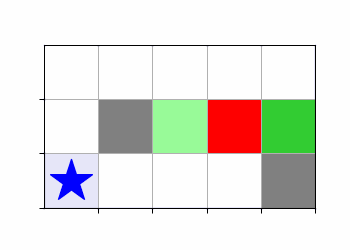

In [11]:
# from util.gridworld import Grid, GridMDP, run_simulation, RANDOM_POLICY

WORLD_GRID = Grid([
    'EEEEE',
    'EWTNG',
    'SEEEW',
])

MDP = GridMDP(WORLD_GRID, gamma=0.9)

run_simulation(MDP, RANDOM_POLICY)

## Exponential Smoothing

How do we refine the expected value of a variable `X` given a series of samples? One technique that
we will use extensively is iteratively applying an
[_exponential moving average_](https://en.wikipedia.org/wiki/Exponential_smoothing) of the samples.

$$
X_{t+1} =  (1 - \alpha) X_t + \alpha X_{t+1}
$$

Basically, the adjusted value after sampling is a "blend" of the old value adjusted by the scaled
value of the new sample. $\alpha$ is the scaling factor (or, _learning rate_). We can rewrite the
above as:

$$
X_{t+1} =  X_t + \alpha (X_{t+1} - X_t)
$$

Where the difference between the new and old value is effectively an error $\delta$ scaled by the
learning rate $\alpha$. You will see why this formula is very important shortly.

In [7]:
import numpy as np

# Samples 1M values from a normal distribution with mean pi.
samples = np.random.normal(loc=3.14159265, scale=1.618033, size=(1_000_000,))

def estimate_mean(samples, alpha=0.0001) -> float:
    """Approximates the expected value using exponential smoothing."""
    value = samples[0]
    for sample in samples[1:]:
        # TODO: Update the value using the exponential smoothing formula.
        value = alpha*sample + (1 - alpha)*value
    return value

# This should print a value very close to 3.14 :)
print(f'Estimated expected value: {estimate_mean(samples):.2f}')

Estimated expected value: 3.13


## Monte Carlo Methods

Monte Carlo methods apply to episodic tasks. The intuition is that we can simulate entire episodes
and compute the actual return with which we can then update our value function.

$$
Q(S_t, A_t) \leftarrow Q(S_t, A_t) + \alpha [G_t - Q(S_t, A_t)]
$$

Monte Carlo methods do not introduce _bias_ in the estimation (because they use the actual return at
the end of the episode), but they might have high _variance_.

### Episode Generation

In [8]:
# from util.gridworld import GridEnv, State, Action
from typing import Callable, TypeAlias

# For simplicity, we define a policy as a function that returns an action given a state.
# TODO: Define the 'Policy' typealias.
# Policy = lambda [state]: Action.RIGHT

# An episode instead is a list of tuples (state, action, reward).
# TODO: Define the 'Episode' typealias.
# Episode = [(State, Action, float)]

In [27]:
# Test our definition
# assert Policy == Callable[[State], Action]
# assert Episode == list[tuple[State, Action, float]]

In [9]:
def generate_episode(env: GridEnv, policy: Policy, max_t=10):
    """Generates an Monte Carlo episode in the Grid World environment GridEnv."""
    t = 0
    episode = []
    state = env.reset()
    while t < max_t:
        # TODO: select an action via the policy
        action: Action = policy(state)
        # TODO: get next_state, reward, done from the environment.
        next, reward, done = env.step(action)
        # TODO: record the step in the episode list.
        episode.append((state, action, reward))
        # TODO: Update state, time, and check for completion.
        t += 1
        state = next
        if done:
           break
    return episode

In [12]:
# Test
test_env = GridEnv(MDP)
test_policy = lambda _: Action.LEFT
test_episode = generate_episode(test_env, test_policy, max_t=3)
assert len(test_episode) == 3
assert test_episode[0] == (State(0, 0), Action.LEFT, 0.0)
assert test_episode[1] == (State(0, 0), Action.LEFT, 0.0)
assert test_episode[2] == (State(0, 0), Action.LEFT, 0.0)

test_policy = lambda s: Action.UP if s == State(3, 0) else Action.RIGHT
test_episode = generate_episode(test_env, test_policy)
assert len(test_episode) == 4
assert test_episode[0] == (State(0, 0), Action.RIGHT, 0.0)
assert test_episode[1] == (State(1, 0), Action.RIGHT, 0.0)
assert test_episode[2] == (State(2, 0), Action.RIGHT, 0.0)
assert test_episode[3] == (State(3, 0), Action.UP, -9.0)

But _how_ do we choose the actions in our Monte Carlo algorithm?

### Greedy and ε-greedy Policy

A _greedy_ policy always chooses the action that maximizes the Q function in the current state.

An _ε-greedy_ policy chooses any other action (other than the best action) with probability
$\frac{\epsilon}{n_A}$, where $n_A$ is the number of available actions. Hence, if ε is `1`,
the policy becomes the random policy; if ε is `0`, the policy is greedy instead.

In [13]:
# from util.gridworld import QTable

def greedy_policy(qtable: QTable) -> Policy:
    """Returns the greedy policy for the specified QTable."""
    # TODO: Return the policy lambda for action selection using the best action from QTable.
    table = qtable.table
    state = State(0, 0) # start state
    policy_dict = {}
    for state in table:
        policy_dict[state] = qtable.best_action(state)

    return lambda state: policy_dict[state]

In [14]:
# Test the implementation
state_0 = State(0, 0)
state_1 = State(1, 0)
test_qtable = QTable([state_0, state_1], [1, 2, 3, 4])

test_qtable[state_0, Action.DOWN]  = 0.5
test_qtable[state_0, Action.LEFT]  = 1.5
test_qtable[state_0, Action.RIGHT] = 0.8
test_qtable[state_1, Action.UP]    = 0.1

test_greedy_policy = greedy_policy(test_qtable)

assert test_greedy_policy(state_0) == Action.LEFT
assert test_greedy_policy(state_1) == Action.UP

In [15]:
# from util.gridworld import QTable

def epsilon_greedy_policy(qtable: QTable, epsilon: float) -> Policy:
    """Returns the epsilon-greedy policy for the specified QTable."""
    def choose_action(state: State) -> Action:
        # TODO: The probability of the best action is (1 - epsilon + epsilon / nA), while the
        #       other actions have probability (epsilon / nA). Compute those and choose the action.
        #       Use np.random.choice for sampling :)

        '''
        n <- uniform random number between 0 and 1
        if n < epsilon
            A <- random action from the action space
        else:
            A <- maxQ(S, .)
        return A
        '''
        try:

            actions = qtable.table[state]

            now_prob = random.random() # (random variable between 0 and 1)

            if now_prob < epsilon:
                # choose a randome action from action_space
                action = random.choice([1, 2, 3, 4])

            else:
                # qtable.best_action for that state
                action = qtable.best_action(state)

            return action
        except Exception as e:
            breakpoint()

    return choose_action

In [16]:
# Test the implementation
# Approximate tests... hopefully good enough to find big bugs :)
state_0 = State(0, 0)
state_1 = State(1, 0)
test_qtable = QTable([state_0, state_1], [1, 2, 3, 4])

test_qtable[state_0, Action.DOWN]  = 0.5
test_qtable[state_0, Action.LEFT]  = 1.5
test_qtable[state_0, Action.RIGHT] = 0.8
test_qtable[state_1, Action.UP]    = 0.1

def probe_actions(policy, state) -> list[Action]:

    ll = [policy(state) for _ in range(5_000)]
    dd = dict.fromkeys(ll)
    return dd

test_egreedy_policy = epsilon_greedy_policy(test_qtable, epsilon=1.0)
assert len(probe_actions(test_egreedy_policy, state_0)) == 4
assert len(probe_actions(test_egreedy_policy, state_1)) == 4

test_egreedy_policy = epsilon_greedy_policy(test_qtable, epsilon=0.0)
assert len(probe_actions(test_egreedy_policy, state_0)) == 1
assert len(probe_actions(test_egreedy_policy, state_1)) == 1

**Note:** This implementation technique (i.e., returning a function) is not optimal and definitely
not efficient. But it serves well for learning purposes.

#### Decay Epsilon with Generator

In [17]:
def epsilon_gen(eps_start=1.0, eps_decay=0.99999, eps_min=0.05):
    """Convenient generator function to generate and decay epsilon."""
    # TODO: eps starts at eps_start :)
    eps = eps_start
    while True:
        yield eps
        eps = max(eps_min, eps*eps_decay)

In [18]:
# Test the implementation!
eps = epsilon_gen(1.0, 0.5, 0.1)

assert next(eps) == 1.0
assert next(eps) == 0.5
assert next(eps) == 0.25
assert next(eps) == 0.125
assert next(eps) == 0.1
assert next(eps) == 0.1

### Monte Carlo Algorithm

In [19]:
def monte_carlo(env: GridEnv, num_episodes, alpha=0.02, eps_start=1.0, start_q: QTable = State(0, 0)):
    """A Monte Carlo algorithm for reinforcement learning."""
    # TODO: Initialize the QTable (use start_q if provided, you'll see why later)
    grid = env.mdp
    all_states = grid.all_states
    all_actions = [1, 2, 3, 4]
    Q = QTable(all_states, all_actions)

    # TODO: Prepare to generate epsilon creating the generator.
    eps_generator = epsilon_gen(eps_start)
    # epsilon = next(eps_generator)

    # Iterate until we reached the maximum number of episodes for learning.
    for i_episode in range(1, num_episodes + 1):
        # TODO: Generate an episode by following epsilon-greedy policy.
        epsilon = next(eps_generator)

        policy = epsilon_greedy_policy(Q, epsilon)
        episode = generate_episode(env, policy, max_t = 20)

        # TODO: Unpack the episode in a tuple of (list[states], list[actions], list[rewards]).
        #       Hint: use the zip function!
        _1, _2, _3 = zip(*episode)
        states, actions, rewards = list(_1), list(_2), list(_3)

        # TODO: Conveniently compute the discounts first. We can do this b/c we can compute all the
        #       expected returns at each timestep (having all the rewards).
        #       The discounts are: [1, gamma, gamma^2, gamma^3, ...] for the length of the episode.
        gamma = env.mdp.gamma
        discounts = [gamma**i for i in range(len(episode))]

        # For each step / transition in the environment, let's update the QTable according to the
        # update rule of Monte Carlo methods defined above.

        for t, state in enumerate(states):
            # TODO: Get the action at timestep `t` and the current state-action value.
            action = actions[t]
            old_Q = Q.table[state]

            # TODO: Compute the total return. Recall that:
            #       G_0 = R_1 + gamma * R_2 + gamma^2 * R_3 + ... (R1 is found at index 0)
            #       Hint: sum rewards _from_ `t` onward, while select discounts _until_ `t`. That is
            #       because discounts always start from the beginning even if rewards "shift".

            G_t = 0.0
            for idx, r in enumerate(rewards[t:]):
                G_t += r*discounts[idx]

            # 𝑄(𝑆𝑡,𝐴𝑡) ← 𝑄(𝑆𝑡,𝐴𝑡) + 𝛼[𝐺𝑡−𝑄(𝑆𝑡,𝐴𝑡)]
            Q[state, action] = Q[state, action] + alpha*(G_t - Q[state, action])
            # print(state, action, Q[state, action])
        # Monitor progress
        if i_episode % 1000 == 0:
            print(f"\rEpisode {i_episode}/{num_episodes}.", end="")

    # TODO: Determine the optimal policy  (i.e., the greedy policy on the computed QTable).
    policy = epsilon_greedy_policy(Q, 0.)
    return policy, Q

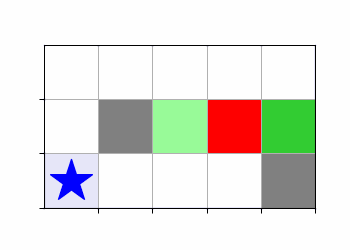

In [40]:
ENV = GridEnv(MDP)

# With minimal exploration
biased_q = QTable(ENV.mdp.all_states, ENV.mdp.all_actions)
biased_q[State(0, 0), Action.RIGHT] = 0.1
biased_q[State(1, 0), Action.RIGHT] = 0.1
biased_q[State(2, 0), Action.UP]    = 0.1

minimal_exploration_policy, Q = monte_carlo(ENV, 200, eps_start=0.05, start_q=biased_q)
run_simulation(ENV.mdp, minimal_exploration_policy)

Episode 100000/100000.

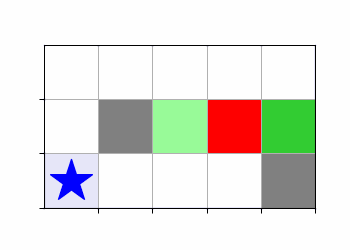

In [43]:
# With exploration
optimal_policy, Q = monte_carlo(ENV, 100000, start_q=biased_q)
run_simulation(ENV.mdp, optimal_policy)

Episode 50000/50000.

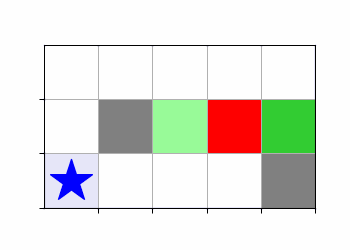

In [51]:
# With exploration
optimal_policy, Q = monte_carlo(ENV, 50000, alpha = 0.1, start_q=biased_q, eps_start = 1.)
run_simulation(ENV.mdp, optimal_policy)

### Exploration vs. Exploitation Tradeoff

We can prove that MC converges to the optimal policy when these conditions are met:

 * Every state-action pair is visited infinitely many times; and
 * The policy converges to a policy that is greedy with respect to the action-value function Q.

These are called the GLIE (Greedy in the Limit with Infinite Exploration) conditions, and guarantee
that the agent continues exploring for all time steps, and grdually exploits more exploring less.

Try to tune `alpha` and `epsilon` and see the effects on the performance of the algorithm!

## Temporal Difference Methods

Monte Carlo methods need to wait until the end of the episode to update our value estimates. Could
we find a way to integrate knowledge earlier than that? Temporal Difference (TD) methods come to the
rescue: they update the current value estimate based on the immediate reward and _another_ estimate.
Hence, the update rule looks something like this:

$$
Q(S_t, A_t) \leftarrow Q(S_t, A_t) + \alpha \{[R_t + \gamma V^{estimate}(S_{t+1})] - Q(S_t, A_t)\}
$$


$R_t + \gamma V^{estimate}(S_{t+1})$ is called the _TD target_. If our estimate was perfect, you can
notice it is effectively equivalent to $G_t$. Then, the _TD error_ $\delta^{TD}$ is:
$TD^{target} - Q(S_t, A_t)$. The equation above can be simplified as:

$$
Q(S_t, A_t) \leftarrow Q(S_t, A_t) + \alpha \delta^{TD}
$$

Choosing the estimate of the value function is what differentiates various TD algorithms.

### Q Learning

Q Learning is probably the most popular TD algorithm. In Q Learning, we choose the estimate of the
next value as: $\max Q(S_{t+1}, A_{t+1})$.

In [25]:
def q_learning(env: GridEnv, num_episodes, alpha=0.02, max_t=10):
    """Runs Q Learning."""
    # TODO: Initialize the QTable, and the epsilon generator.

    grid = env.mdp
    all_states = grid.all_states
    all_actions = [1, 2, 3, 4]
    Q = QTable(all_states, all_actions)

    eps_gen = epsilon_gen(1.)

    # Run for the maximum number of episodes passed as input.
    for i_episode in range(1, num_episodes+1):
        t = 0
        state = env.reset()
        epsilon = next(eps_gen)
        while True:

            # TODO: Select an action with an epsilon greedy policy using Q.
            policy = epsilon_greedy_policy(Q, epsilon) # choose_action(state: State) - callable with state as an argument
            action = policy(state)
            # TODO: Interact with the environment
            next_state, reward, done = env.step(action)
            # TODO: Store the current Q(s,a) value.
            cur_value = Q[state, action] # Q(s,a)
            # TODO: Determine the next_action using maxQ.
            next_action = Q.best_action(next_state)
            # TODO: Compute the TD target.
            td_target = reward + env.mdp.gamma*Q[next_state, next_action] # R + γ * max(Q(s',a'))
            # TODO: Compute the TD error.
            td_error  =  td_target - cur_value # [R + γ * max(Q(s',a')) - Q(s,a)]
            # TODO: Update Q with the temporal-difference update rule.
            # Q(s,a) = Q(s,a) + α[R + γ * max(Q(s',a')) - Q(s,a)]
            Q[state, action] = cur_value + alpha*td_error
            # Update the state for the next cycle, and check for episode completion.
            state = next_state
            t = t + 1
            if done or t >= max_t:
                break
        # Monitor and debugging messages.
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}".format(i_episode, num_episodes), end="")
    # TODO: Return the optimal policy as the greedy policy on Q.
    policy = greedy_policy(Q)
    return policy, Q

Episode 100000/100000

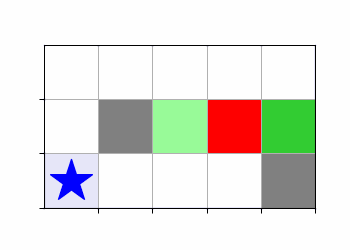

In [26]:
ENV = GridEnv(MDP)

# With minimal exploration

opt_policy, Q = q_learning(ENV, 100_000)
run_simulation(ENV.mdp, opt_policy)

In order to converge, Q Learning needs to explore enough and eventually make the learning rate small
enough, but not decrease it too quickly either... :)

### Off-Policy vs. On-Policy

Q Learning is an _off-policy_ algorithm: the policy function is learnt by estimating the value of
the next state using a separate policy (i.e., the greedy policy, maximizing the current Q value)
compared to the policy that is actually followed (i.e., $\epsilon$-greedy).

That is different from _on-policy_ learning, where we learn and refine the policy function using
actions taken via our current followed and learnt policy $\pi(a|s)$. See [this post](https://stats.stackexchange.com/questions/184657/what-is-the-difference-between-off-policy-and-on-policy-learning) for a more in-depth explanation.

## Tabular Methods Limitations

Cannot scale to large state / action spaces. Discretization is one approach, but there are better ones :)

## Appendix

### N-step Bootstrapping

Sometimes neither Monte Carlo nor TD are the best fit. We should think them like the end of a
spectrum: TD uses the immediate next reward, MC uses all (possibly infinite) rewards. Nothing
prevents us to use any intermetiate number of rewards and then an estimate: this process is called
_n-step bootstrapping_. More details in the Sutton and Barto book :)